In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from datasets import load_dataset
from timm.optim import Mars
from torchvision.transforms.v2 import (
    Compose, Resize, RandomCrop, CenterCrop, RandomGrayscale, RandomRotation, RandomHorizontalFlip, RandomVerticalFlip,
    PILToTensor, ToPILImage, MixUp )
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('high')
device = "cuda:1"
dataset_train = load_dataset('danjacobellis/pathmnist_224',split='train')
dataset_valid = load_dataset('danjacobellis/pathmnist_224',split='validation')

In [3]:
labels = [sample['label'][0] for sample in dataset_train]
class_counts = Counter(labels)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [4]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/128)*6e-4
config.min_lr = config.max_lr/100
config.plot_update = 128
config.epochs = 1000
config.lr_scale = 12
config.lr_offset = 0.25
config.lr_pow = 6
config.weight_decay = 0.
config.num_workers = 12
config.image_size = 272
config.crop_size = 256

# model config
config.channels = 3
config.J = 4
config.embed_dim = 512
config.dim_head = 64
config.classifier_num_classes = 9
config.checkpoint = False

In [5]:
from pytorch_wavelets import DWTForward
from tft.transforms import WPT2D
from tft.models import TFTClassifier

wt = DWTForward(J=1, mode='periodization', wave='bior4.4')
wpt = WPT2D(wt).to(device)
model = TFTClassifier(config,wpt).to(device)

for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint['model'])

0.0 	 wpt
24.974848 	 ascan
0.306176 	 pool
0.004617 	 classifier


In [6]:
mix_transform = MixUp(num_classes=config.classifier_num_classes, alpha=1.)
rand_crop = Compose([
    Resize(size=config.image_size, interpolation=PIL.Image.Resampling.LANCZOS),
    RandomRotation(degrees=15),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomGrayscale(p=0.2),
    RandomCrop(size=config.crop_size),
    PILToTensor()
])
cent_crop = Compose([
    Resize(size=config.image_size,interpolation=PIL.Image.Resampling.LANCZOS),
    CenterCrop(size=config.crop_size),
    PILToTensor()
])
def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['label'][0]
        x[i_sample,:,:,:] = rand_crop(sample['image'])
    return x, y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['label'][0]
        x[i_sample,:,:,:] = cent_crop(sample['image'])
    return (x,y)

In [7]:
optimizer = Mars(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

import numpy as np

def EmPL(x):
    return np.exp(-np.power(np.log(x), config.lr_pow))
        
def EmPL_sched(i_step, config):
    x = i_step / (config.steps_per_epoch/config.plot_update)
    sched = EmPL(x/(config.lr_scale*config.steps_per_epoch/config.plot_update)+config.lr_offset)
    scale = config.max_lr
    lr = scale * sched
    return lr / config.min_lr
    
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)

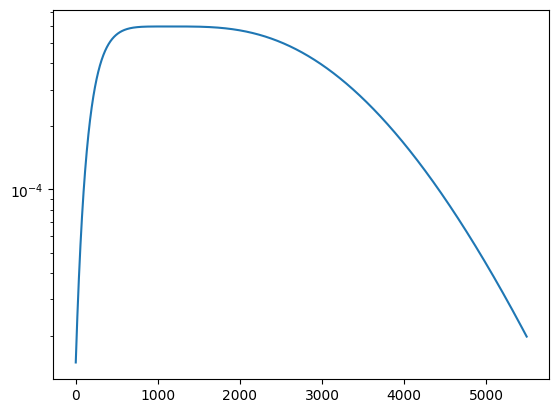

In [9]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# import matplotlib.pyplot as plt
# plt.semilogy(learning_rates)

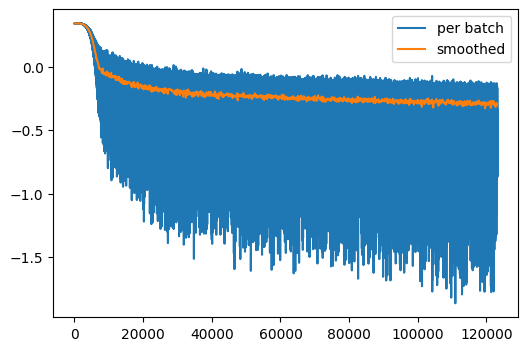

In [ ]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        sampler=sampler,
        # shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(device).to(torch.float)/255
        x, y = mix_transform(x, y)

        logits = model(x-0.5)
        loss = torch.nn.CrossEntropyLoss()(input=logits, target=y)

        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(torch.long).to(device)
        x = x.to(device).to(torch.float)/255
        with torch.no_grad():
            logits = model(x-0.5)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= len(dataset_valid)
    
    mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")

In [9]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

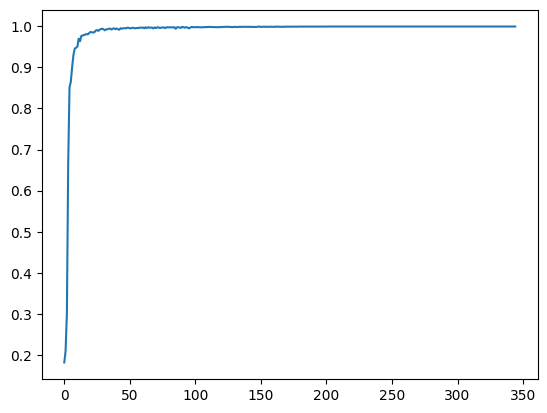

In [10]:
plt.plot(valid_acc)

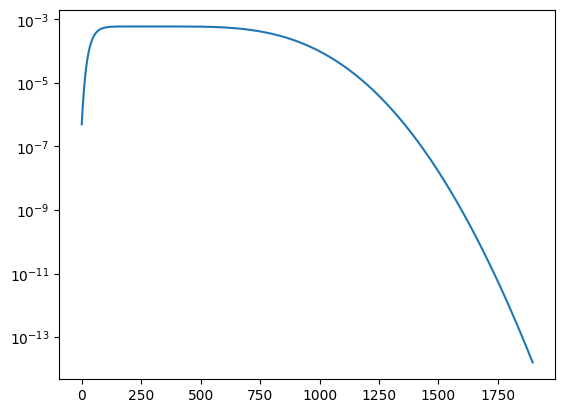

In [11]:
plt.semilogy(learning_rates)

/tmp/ipykernel_2531522/2013070528.py:2: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,2])


(0.4200094393591939, 2)

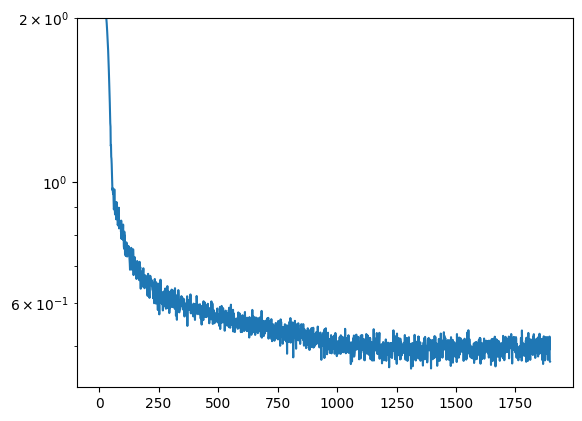

In [12]:
plt.semilogy(smoothed_y)
plt.ylim([0,2])

In [13]:
torch.save({
    'i_epoch': i_epoch,
    'learning_rates': learning_rates,
    'smoothed_y': smoothed_y,
    'valid_acc': valid_acc,
    'config': config,
    'model': model.state_dict(),
}, f"../../hf/tft/pathmnist_v0.2c.pth")

---

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset
from torchvision.transforms.v2 import (
    Compose, Resize, CenterCrop,
    PILToTensor )
from fastprogress.fastprogress import progress_bar

In [2]:
torch.set_float32_matmul_precision('high')
device = "cuda:0"
dataset_test = load_dataset('danjacobellis/pathmnist_224', split='test')

config = SimpleNamespace()
config.batch_size = 128
config.num_workers = 12
config.image_size = 272
config.crop_size = 256
config.channels = 3
config.J = 4
config.embed_dim = 512
config.dim_head = 64
config.classifier_num_classes = 9
config.checkpoint = "../../hf/tft/pathmnist_v0.2c.pth"

In [3]:
from pytorch_wavelets import DWTForward
from tft.transforms import WPT2D
from tft.models import TFTClassifier

wt = DWTForward(J=1, mode='periodization', wave='bior4.4')
wpt = WPT2D(wt).to(device)
model = TFTClassifier(config, wpt).to(device)

checkpoint = torch.load(config.checkpoint, map_location="cpu")
model.load_state_dict(checkpoint['model'])

/tmp/ipykernel_643983/1931001648.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint, map_location="cpu")


<All keys matched successfully>

In [4]:
cent_crop = Compose([
    Resize(size=config.image_size, interpolation=PIL.Image.Resampling.LANCZOS),
    CenterCrop(size=config.crop_size),
    PILToTensor()
])

def test_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['label'][0]
        x[i_sample,:,:,:] = cent_crop(sample['image'])
    return x, y

In [5]:
model.eval()
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    drop_last=False,
    pin_memory=True,
    collate_fn=test_collate_fn
)

test_acc = 0
pb_test = progress_bar(data_loader_test)
for i_batch, (x, y) in enumerate(pb_test):
    y = y.to(torch.long).to(device)
    x = x.to(device).to(torch.float)/255
    with torch.no_grad():
        logits = model(x-0.5)
    test_acc += torch.sum(logits.argmax(dim=1) == y).item()

test_acc /= len(dataset_test)
print(f'Test Accuracy: {test_acc:.4g}')


Test Accuracy: 0.9286
